In [1]:
!pip install sqlalchemy
!pip install pyodbc

In [2]:
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, String, Float, select, func
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

In [3]:
def new_engine(dialect, server, database, integrated_security=True):
    if integrated_security:
        #For windows authentication
        eng = f"{dialect}://{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server"
    else:
        #For SQL server Authentication
        eng = f"{dialect}://{user}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
    print(eng)
    return create_engine(eng)

In [4]:
engine = new_engine('mssql','IMS', 'AdventureWorks2022', integrated_security=True)

mssql://IMS/AdventureWorks2022?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server


In [5]:
#1.In this query we include four tables, Sales.SalesPerson,Sales.SalesOrderHeader,Person.Person,HumanResources.Employee
#2.We are going to look at the 'Sales Person stats based on Sales Quota vs Total Sales' order by TotalSales Desc
sql_query = """
   SELECT 
    A.BusinessEntityID, 
    ROUND(SUM(B.TotalDue), 2) AS TotalSales, 
    A.SalesQuota,
	C.FirstName,
	C.LastName,
	D.Gender,
	D.Maritalstatus,
	D.JobTitle
FROM Sales.SalesPerson A
   Inner JOIN Sales.SalesOrderHeader B ON A.BusinessEntityID = B.SalesPersonID
   Inner JOIN Person.Person C ON A.BusinessEntityID = C.BusinessEntityID
    Inner JOIN HumanResources.Employee D ON A.BusinessEntityID = D.BusinessEntityID
	    WHERE YEAR(B.OrderDate) BETWEEN 2011 AND 2014

GROUP BY A.BusinessEntityID, A.SalesQuota,C.FirstName, C.LastName, D.Gender, D.MaritalStatus,D.JobTitle
ORDER BY TotalSales DESC;
"""


In [6]:
df = pd.read_sql_query(sql_query, engine)

In [7]:
df.head(17)

,BusinessEntityID,TotalSales,SalesQuota,FirstName,LastName,Gender,Maritalstatus,JobTitle
0,276,11695019.06,250000.0,Linda,Mitchell,F,M,Sales Representative
1,277,11342385.90,250000.0,Jillian,Carson,F,S,Sales Representative
2,275,10475367.08,300000.0,Michael,Blythe,M,S,Sales Representative
3,289,9585124.95,250000.0,Jae,Pak,F,M,Sales Representative
4,279,8086073.68,300000.0,Tsvi,Reiter,M,M,Sales Representative
5,281,7259567.88,250000.0,Shu,Ito,M,M,Sales Representative
6,282,6683536.66,250000.0,José,Saraiva,M,M,Sales Representative
7,290,5087977.21,250000.0,Ranjit,Varkey Chudukatil,M,S,Sales Representative
8,283,4207894.60,250000.0,David,Campbell,M,S,Sales Representative
9,278,4069422.21,250000.0,Garrett,Vargas,M,M,Sales Representative


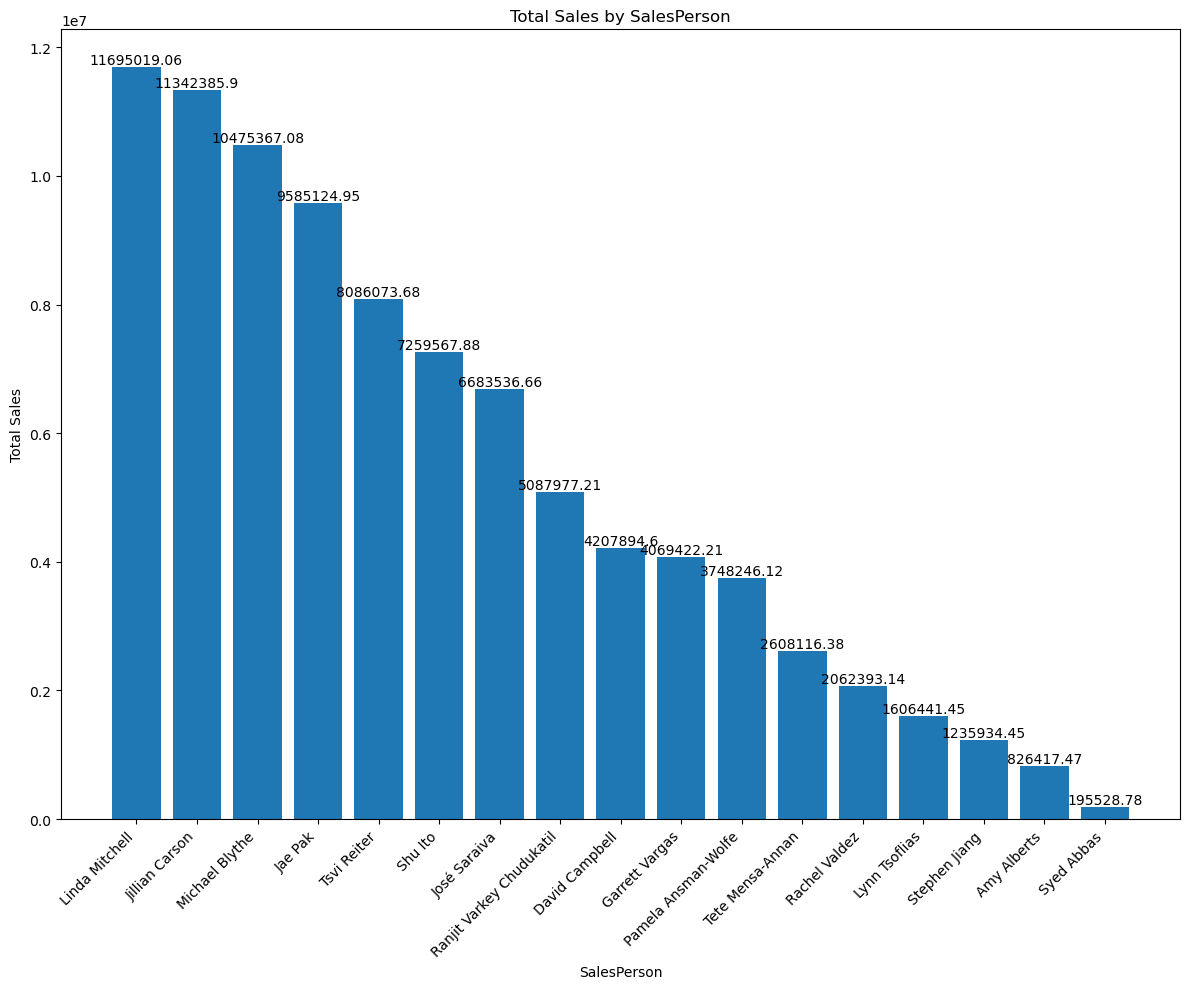

In [8]:
# Plotting TotalSales by SalesPerson
plt.figure(figsize=(12, 10))
bars = plt.bar(df['FirstName'] + ' ' + df['LastName'], df['TotalSales'])

# Display numerical values on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.title('Total Sales by SalesPerson')
plt.xlabel('SalesPerson')
plt.ylabel('Total Sales')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [9]:
# Calculate the mean and standard deviation of TotalSales by salesperson
mean_total_sales = df['TotalSales'].mean()
std_dev_total_sales = df['TotalSales'].std()
print(df['TotalSales'].mean())

5339732.177647059


In [10]:
# This code is using the Student's t-distribution to calculate the confidence interval.
confidence_interval = stats.t.interval(0.95, len(df['TotalSales']) - 1, loc=mean_total_sales, scale=std_dev_total_sales / len(df['TotalSales']) ** 0.5)

In [11]:
print(f"95% Confidence Interval for Total Sales (2011-2014): {confidence_interval}")


95% Confidence Interval for Total Sales (2011-2014): (3368614.6625854014, 7310849.692708716)


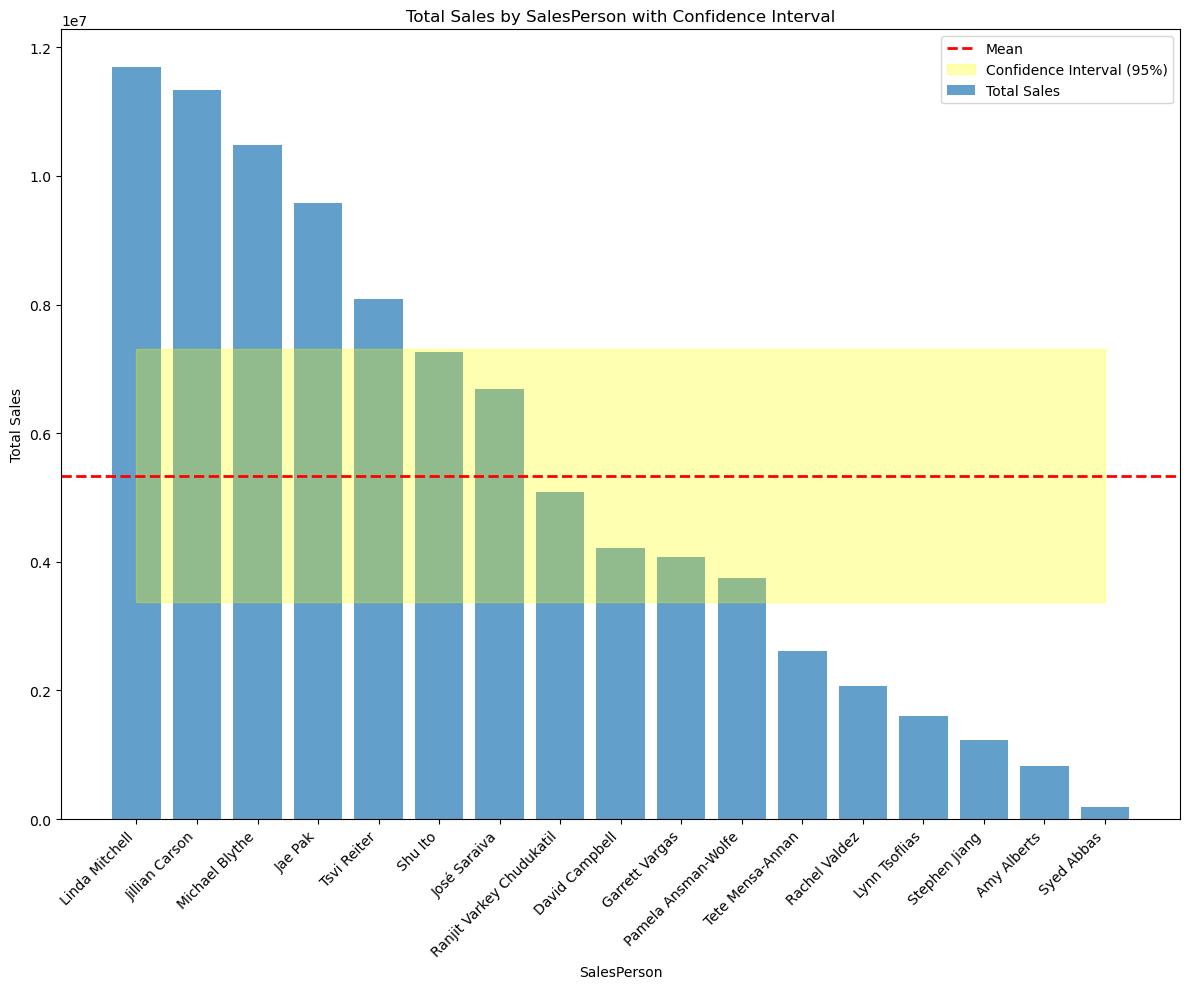

In [12]:
# Plotting TotalSales by SalesPerson with confidence interval
plt.figure(figsize=(12, 10))
plt.bar(df['FirstName'] + ' ' + df['LastName'], df['TotalSales'], alpha=0.7, label='Total Sales')
plt.axhline(mean_total_sales, color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.fill_between([0, len(df) - 1], confidence_interval[0], confidence_interval[1], color='yellow', alpha=0.3, label='Confidence Interval (95%)')
plt.title('Total Sales by SalesPerson with Confidence Interval')
plt.xlabel('SalesPerson')
plt.ylabel('Total Sales')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
#Common Table expression  is used to simplify coding and help to get the result as quickly as possible.
#A CTE SQL query that analyzes sales data for total quantity sold within different quantity ranges and the number of products using Common Table Expressions (CTEs). 
#It organizes products based on their total quantity sold and provides a count and sum for each category.

cte_sql = """
WITH details AS (
  SELECT 
    Product.Name AS ProductName,
    YEAR(SalesOrderDetail.ModifiedDate) 'Year', 
    SUM(SalesOrderDetail.OrderQty) AS TotalQuantitySold
  FROM Sales.SalesOrderDetail AS SalesOrderDetail 
  INNER JOIN Production.Product AS Product
    ON SalesOrderDetail.ProductID = Product.ProductID
  GROUP BY Product.Name, YEAR(SalesOrderDetail.ModifiedDate)
), rangedetails AS (
 SELECT ProductName, TotalQuantitySold, CASE
   WHEN TotalQuantitySold BETWEEN 0 AND 1000 THEN '0-1000'
   WHEN TotalQuantitySold BETWEEN 1000 AND 2000 THEN '1000-2000'
   WHEN TotalQuantitySold BETWEEN 2000 AND 3000 THEN '2000-3000'
   WHEN TotalQuantitySold >= 3000 THEN '3000-'
   ELSE 'Unknown'
 END AS rng
 FROM details
)
SELECT rng 'RANGE', 
       COUNT(rng) 'Count of products', 
       SUM(TotalQuantitySold) 'Total Quantity Sold'
FROM rangedetails
GROUP BY rng
ORDER BY RANGE;
"""

In [14]:
df = pd.read_sql_query(cte_sql, engine)

In [15]:
df.head(4)

,RANGE,Count of products,Total Quantity Sold
0,0-1000,541,159798
1,1000-2000,51,67739
2,2000-3000,14,33520
3,3000-,4,13857


Values for plotting:
RANGE: ['0-1000' '1000-2000' '2000-3000' '3000-']
Count of products: [541  51  14   4]
Total Quantity Sold: [159798  67739  33520  13857]


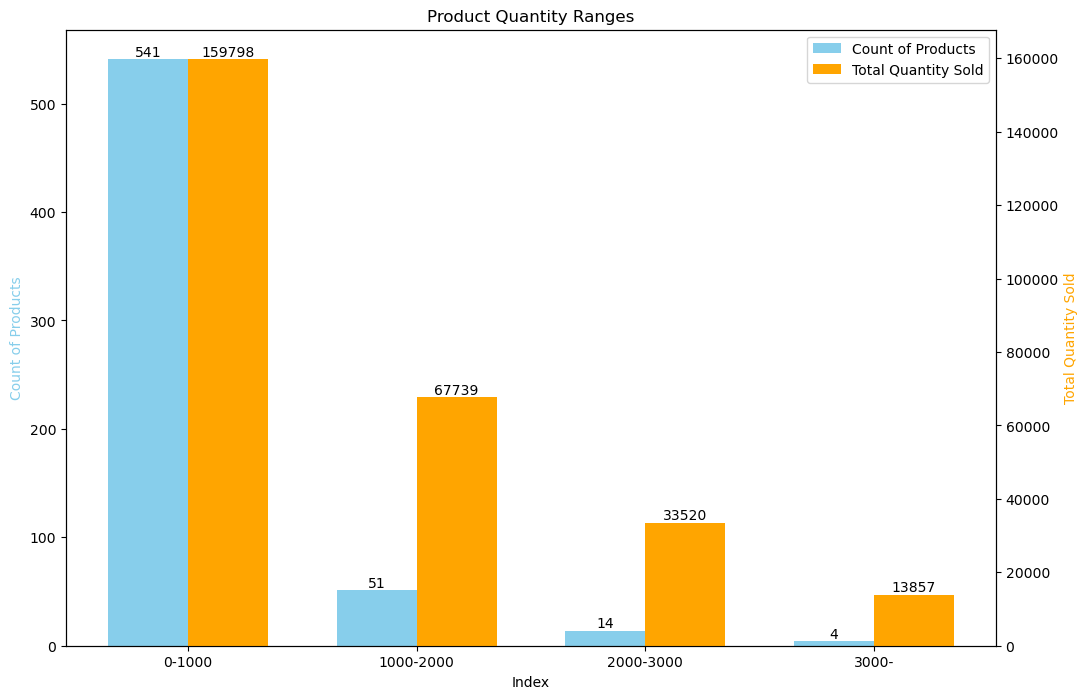

In [16]:
# Plotting the data
fig, ax1 = plt.subplots(figsize=(12, 8))
# Debugging: Print values used for plotting
print("Values for plotting:")
print("RANGE:", df['RANGE'].values)
print("Count of products:", df['Count of products'].values)
print("Total Quantity Sold:", df['Total Quantity Sold'].values)
# Bar plot for count of products
bar_width = 0.35
index = range(len(df))
bars1 = ax1.bar(index, df['Count of products'], width=bar_width, color='skyblue', label='Count of Products')
ax1.set_xlabel('Index')
ax1.set_ylabel('Count of Products', color='skyblue')
ax1.set_xticks([i + bar_width/2 for i in index])
ax1.set_xticklabels(df['RANGE'])

# Adding numeric labels on top of the first set of bars
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval, round(yval), ha='center', va='bottom', color='black')

# Create a second set of bars for total quantity sold
ax2 = ax1.twinx()
bars2 = ax2.bar([i + bar_width for i in index], df['Total Quantity Sold'], width=bar_width, color='orange', label='Total Quantity Sold')
ax2.set_ylabel('Total Quantity Sold', color='orange')

# Adding numeric labels on top of the second set of bars
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval, round(yval), ha='center', va='bottom', color='black')

# Adding labels to the legend on the first axis
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Title
plt.title('Product Quantity Ranges')

# Display the plot
plt.show()

In [17]:
#Products sold per year for each product.
sql_query1 ="""
SELECT 
    Product.Name AS ProductName,
YEAR(SalesOrderDetail.ModifiedDate) 'Year', 
    SUM(SalesOrderDetail.OrderQty) AS TotalQuantitySold
FROM Sales.SalesOrderDetail AS SalesOrderDetail 
INNER JOIN Production.Product AS Product
    ON SalesOrderDetail.ProductID = Product.ProductID
GROUP BY Product.Name, YEAR(SalesOrderDetail.ModifiedDate)
ORDER BY Product.Name,TotalQuantitySold DESC;
"""

In [18]:
df = pd.read_sql_query(sql_query1, engine)

In [19]:
df.head(15)

,ProductName,Year,TotalQuantitySold
0,All-Purpose Bike Stand,2013,136
1,All-Purpose Bike Stand,2014,113
2,AWC Logo Cap,2013,3768
3,AWC Logo Cap,2012,2048
4,AWC Logo Cap,2014,1950
5,AWC Logo Cap,2011,545
6,Bike Wash - Dissolver,2013,2165
7,Bike Wash - Dissolver,2014,1154
8,Cable Lock,2012,773
9,Cable Lock,2013,314
